## Here I want to load and prepare other datasets such as data relating to weather and latitude

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error

### Create a distance from equator value per country

In [2]:
lat_long = pd.read_csv("../../raw_data/Country_lat_long.csv")

In [3]:
lat_long['Distance_Equator'] = np.log1p(abs(lat_long['Latitude']))

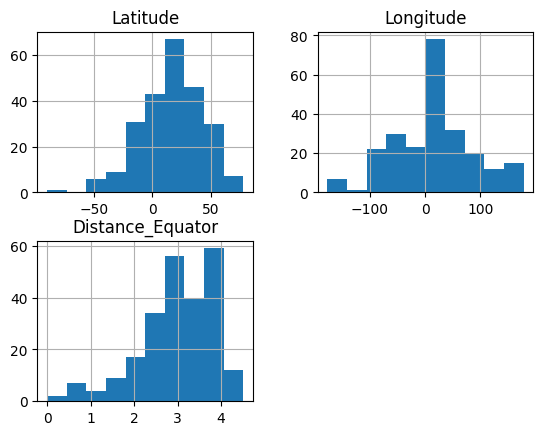

In [4]:
lat_long.hist();

In [5]:
distance_equator = lat_long[['Country', 'Distance_Equator']]

In [6]:
distance_equator.to_parquet('../data/distance_equator.pq')

# See how this new variable affects the model

In [7]:
world_bank_df = pd.read_parquet('../data/world_bank_variables_target.pq')

'Europe & Central Asia', 'Heavily indebted poor countries (HIPC)', 'Timor-Leste', 'Europe & Central Asia (IDA & IBRD countries)', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Fragile and conflict affected situations', 'IDA only', 'Middle income', 'Early-demographic dividend', 'Europe & Central Asia (excluding high income)', 'Low & middle income', 'World', 'Middle East & North Africa', 'Small states', 'Lower middle income', 'Latin America & Caribbean', 'Least developed countries: UN classification', 'High income', 'Arab World', 'South Asia (IDA & IBRD)', 'Africa Western and Central', 'OECD members', 'Pre-demographic dividend', 'Latin America & the Caribbean (IDA & IBRD countries)', 'Sub-Saharan Africa', 'European Union', 'IBRD only', 'Africa Eastern and Southern', 'IDA blend', 'Post-demographic dividend', 'Central Europe and the Baltics', 'Latin America & Caribbean (excluding high income)', 'IDA total', 'Euro area', 'Middle East & North Africa (excluding high income)', 'Pacific island small states', 'Other small states', 'Low income', 'Caribbean small states', 'IDA & IBRD total', 'Sub-Saharan Africa (excluding high income)', 'Middle East & North Africa (IDA & IBRD countries)', 'North America', 'South Asia'

In [8]:
data = pd.merge(world_bank_df, distance_equator, left_on = 'Country_Name', right_on = 'Country', how = 'left')

In [9]:
data[data['Distance_Equator'].isna()]['Country_Name'].unique()

array(['Pre-demographic dividend', 'OECD members', 'Other small states',
       'North America', 'Latin America & Caribbean',
       'Least developed countries: UN classification', 'Low income',
       'Lower middle income', 'Low & middle income',
       'Middle East & North Africa', 'Middle income',
       'Middle East & North Africa (excluding high income)',
       'Timor-Leste', 'Middle East & North Africa (IDA & IBRD countries)',
       'South Asia (IDA & IBRD)',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'World',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Europe & Central Asia (IDA & IBRD countries)',
       'Pacific island small states', 'Post-demographic dividend',
       'South Asia', 'Sub-Saharan Africa (excluding high income)',
       'Sub-Saharan Africa', 'Small states',
       'Central Europe and the Baltics', 'Caribbean small states',
       'Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Early-demogra

#### So all these rows relate to areas, rather than specific countries, so I will drop them

In [10]:
data = data[~data['Distance_Equator'].isna()]

In [11]:
data.head()

,Country_Name,Country_Code,Year,Cereal_Yield,Arable_Land_Percent,Value_Added_AFF,Arable_Land_Person,Freshwater_Withdrawl,Fertilizer,Education_Expenditure,Natural_Resource_Rents,Country,Distance_Equator
0,Norway,NOR,1971.0,8.079401,1.163547,1.804178,0.187304,1.429050,5.563376,1.796640,0.334428,Norway,4.143135
1,Netherlands,NLD,1971.0,8.371358,3.170024,1.758224,0.056718,1.019467,6.661533,1.991730,0.093283,Netherlands,3.979682
2,Nicaragua,NIC,1971.0,6.988136,2.266147,3.306797,0.344867,1.213858,3.261124,1.250483,1.206264,Nicaragua,2.639057
3,Namibia,NAM,1971.0,5.842094,0.583301,3.138460,0.609293,1.185488,1.919471,1.506671,2.041281,Namibia,3.135494
4,Niger,NER,1971.0,6.053970,2.288729,4.196612,1.206025,0.253070,0.022200,0.718947,1.028939,Niger,2.833213


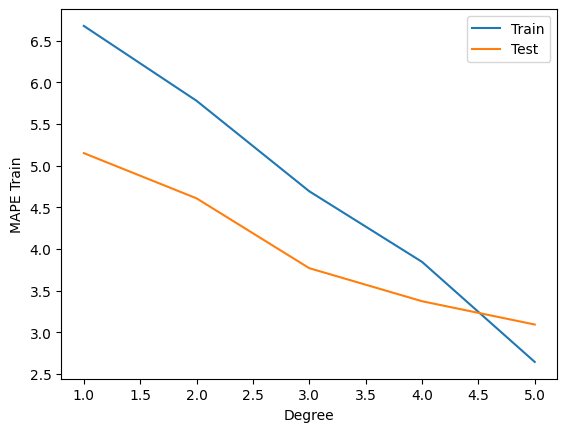

In [12]:
X = data.drop(columns = ['Country_Name', 'Country_Code', 'Cereal_Yield', 'Country', 'Distance_Equator'])
y = data['Cereal_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 84)

scores = []

for degree in np.arange(1, 6):
    pipe = Pipeline([('polynomial', PolynomialFeatures(degree = degree)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    scores.append([degree, mape_train, mape_test])
    
poly_line_reg_scores = pd.DataFrame(scores, columns = ['Degree', 'MAPE Train', 'MAPE Test'])

sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Train', label = 'Train')
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Test', label = 'Test');

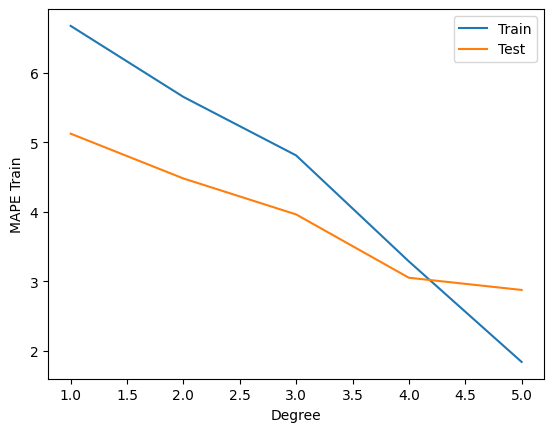

In [13]:
X = data.drop(columns = ['Country_Name', 'Country_Code', 'Cereal_Yield', 'Country'])
y = data['Cereal_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 84)

scores = []

for degree in np.arange(1, 6):
    pipe = Pipeline([('polynomial', PolynomialFeatures(degree = degree)), ('scaler', StandardScaler()), ('lin_reg', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred_test = pipe.predict(X_test)
    y_pred_train = pipe.predict(X_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    
    scores.append([degree, mape_train, mape_test])
    
poly_line_reg_scores = pd.DataFrame(scores, columns = ['Degree', 'MAPE Train', 'MAPE Test'])

sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Train', label = 'Train')
sns.lineplot(data = poly_line_reg_scores, x = 'Degree', y = 'MAPE Test', label = 'Test');

Slight improvements including the distance from equator

## Get the annual average temperature

In [14]:
temp = pd.read_csv("../../raw_data/temp.csv")

In [15]:
temp.head()

,year,country,avg_temp
0,1849,Cote d'Ivoire,25.58
1,1850,Cote d'Ivoire,25.52
2,1851,Cote d'Ivoire,25.67
3,1852,Cote d'Ivoire,NaN
4,1853,Cote d'Ivoire,NaN


In [16]:
temp = temp[temp['year'] > 1969]

In [17]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15180 entries, 121 to 71310
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      15180 non-null  int64  
 1   country   15180 non-null  object 
 2   avg_temp  15180 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 474.4+ KB


In [18]:
temp_missing = (set(data['Country_Name']) - set(temp.country.unique()))
print(len(temp_missing))

36


#### these are the countries not in the temp set
'Maldives', 'Panama', 'Trinidad and Tobago', 'Yemen, Rep.', 'Fiji', 'Paraguay', 'Cuba', 'Togo', 'Jordan', 'Belize', 'Vanuatu', 'Congo, Rep.', 'Eswatini', 'Costa Rica', 'Oman', 'Congo, Dem. Rep.', 'Bhutan', 'Comoros', 'Cyprus', 'Brunei Darussalam', 'Cabo Verde', 'Benin', "Korea, Dem. People's Rep.", 'Israel', 'New Caledonia', 'Korea, Rep.', 'St. Vincent and the Grenadines', 'Cambodia', 'Dominica', 'Barbados', 'Grenada', 'Puerto Rico', 'Gambia, The', 'Myanmar', 'Chad', 'Sao Tome and Principe'

In [19]:
from haversine import haversine

In [20]:
def extract_lat_lon(row):
    lat = row['Latitude']
    long = row['Longitude']
    country = row['Country']
    return country, lat, long    

In [21]:
def haversine_calculation(row, countries_with_temp: list, temperature_df: pd.DataFrame):
    '''
    Taking a country as starting point, we find the nearest country by haversine calculation but limiting the results to those countries that do have temperature values
    '''
    country, lat, long = extract_lat_lon(row)
    country_distance = []
    for row in temperature_df.itertuples():
        if country != row.Country:
            country_distance.append([row.Country, haversine((lat, long), (row.Latitude, row.Longitude), unit = 'km')])
    country_distance = sorted(country_distance,key=lambda l:l[1])
    for cd in country_distance:
        if cd[0] in countries_with_temp:
            return cd[0], cd[1]

In [22]:
countries_with_temp = temp['country'].unique()

lat_long[['Nearest_Country', 'Haversine_Distance']] = lat_long.apply(lambda row: haversine_calculation(row, countries_with_temp), axis = 1).tolist()

In [23]:
lat_long.head()

,ISO 3166 Country Code,Country,Latitude,Longitude,Distance_Equator,Nearest_Country,Haversine_Distance
0,AD,Andorra,42.50,1.50,3.772761,France,391.212647
1,AE,United Arab Emirates,24.00,54.00,3.218876,Qatar,323.922971
2,AF,Afghanistan,33.00,65.00,3.526361,Pakistan,579.526937
3,AG,Antigua and Barbuda,17.05,-61.80,2.893146,Dominican Republic,962.486703
4,AI,Anguilla,18.25,-63.17,2.957511,Dominican Republic,794.610976


In [24]:
set(lat_long[lat_long['Country'].isin(temp_missing)]['Nearest_Country']) - set(temp['country'])

set()

merge the temp with world bank data, identify the missing values, then try replace the misisng countries with the nearest geographiocal neighbours values which I have from haversine distances

#### Create the imputed temp data for countries that we don't have the temperatures for

In [25]:
imputed_temps = pd.DataFrame(columns = ['year', 'country', 'avg_temp'])

for tm in temp_missing:
    neareast_country = lat_long[lat_long['Country'] == tm]['Nearest_Country'].values[0]
    to_steal = temp[temp['country'] == neareast_country]
    to_steal['country'] = tm
    imputed_temps = imputed_temps.append(to_steal)

/home/sean/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
temps_imputed_temps_added = temp.append(imputed_temps)

In [27]:
temps_imputed_temps_added = temps_imputed_temps_added.drop_duplicates()

In [28]:
temps_imputed_temps_added = temps_imputed_temps_added.groupby(['year', 'country'], as_index = False)['avg_temp'].mean()

### Now merge the main dataframe with the temps_imputed_temps_added

In [29]:
data['Year'] = data['Year'].astype(object)

In [30]:
wb_data_equator_temps = pd.merge(left = data, right = temps_imputed_temps_added, left_on = ['Country_Name', 'Year'], right_on = ['country', 'year'])

In [31]:
wb_data_equator_temps = wb_data_equator_temps.drop(columns = ['Country', 'country', 'year'])

In [32]:
wb_data_equator_temps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5934 entries, 0 to 5933
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country_Name            5934 non-null   object 
 1   Country_Code            5934 non-null   object 
 2   Year                    5934 non-null   object 
 3   Cereal_Yield            5934 non-null   float64
 4   Arable_Land_Percent     5934 non-null   float64
 5   Value_Added_AFF         5934 non-null   float64
 6   Arable_Land_Person      5934 non-null   float64
 7   Freshwater_Withdrawl    5934 non-null   float64
 8   Fertilizer              5934 non-null   float64
 9   Education_Expenditure   5934 non-null   float64
 10  Natural_Resource_Rents  5934 non-null   float64
 11  Distance_Equator        5934 non-null   float64
 12  avg_temp                5934 non-null   float64
dtypes: float64(10), object(3)
memory usage: 649.0+ KB


## Add in GDP evolution over time

In [47]:
gdp = pd.read_csv('../../raw_data/gdp-per-capita-maddison-2020.csv')

In [48]:
gdp = gdp[gdp['Year'] > 1969]
gdp = gdp.drop(columns = ['417485-annotations'])

In [49]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 20 to 19875
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Entity          8190 non-null   object 
 1   Code            8077 non-null   object 
 2   Year            8190 non-null   int64  
 3   GDP per capita  8190 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 319.9+ KB


In [52]:
wb_data_equator_temps_gdp = pd.merge(wb_data_equator_temps, gdp, left_on = ['Country_Code', 'Year'], right_on = ['Code', 'Year'])

In [56]:
wb_data_equator_temps_gdp = wb_data_equator_temps_gdp.drop(columns = ['Entity', 'Code'])

In [57]:
wb_data_equator_temps_gdp.head()

,Country_Name,Country_Code,Year,Cereal_Yield,Arable_Land_Percent,Value_Added_AFF,Arable_Land_Person,Freshwater_Withdrawl,Fertilizer,Education_Expenditure,Natural_Resource_Rents,Distance_Equator,avg_temp,GDP per capita
0,Norway,NOR,1971.0,8.079401,1.163547,1.804178,0.187304,1.429050,5.563376,1.796640,0.334428,4.143135,3.24,16692.0
1,Netherlands,NLD,1971.0,8.371358,3.170024,1.758224,0.056718,1.019467,6.661533,1.991730,0.093283,3.979682,9.51,19636.0
2,Nicaragua,NIC,1971.0,6.988136,2.266147,3.306797,0.344867,1.213858,3.261124,1.250483,1.206264,2.639057,26.21,4533.0
3,Namibia,NAM,1971.0,5.842094,0.583301,3.138460,0.609293,1.185488,1.919471,1.506671,2.041281,3.135494,19.64,6258.0
4,Niger,NER,1971.0,6.053970,2.288729,4.196612,1.206025,0.253070,0.022200,0.718947,1.028939,2.833213,29.34,1382.0


## Export parquet


In [58]:
wb_data_equator_temps_gdp.to_parquet('../data/wb_equator_temps_gdp.pq')